# Day 7
## Recurrent Neural Network

In this assignment, we try to create and train a neural network model to predict the emotion (sentiment detection) of a given comment. The comments are describing videos which could be positive or negative.

Here we first try to clean the dataset and then train a recurrent neural network with them. And at the end check the accuracy of this model is measured.

In [1]:
from keras.callbacks import LambdaCallback, TensorBoard
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from matplotlib import pyplot as plt
from keras.preprocessing.text import Tokenizer
from nltk.stem.snowball import SnowballStemmer

import os
import numpy as np
from random import randint

sno = SnowballStemmer('english')

Using TensorFlow backend.


At first, we need a function to clean the sentences. To this aim, we have defined the below function which cleans the texts by first splitting them into words. Then we ignore the word if it's a blank space or punctuation, or is in our predefined stop words. The stop words are the words that convey not much information on their own which can be irrelevant to our tasks.
Afterward, we convert the words to their origin to have the word information instead of different variants of the word. For instance, we change the word `wonderful` to `wonder` and `usually` to `usual`. To do this, we use a function called `sno.stem`.
Finally, the words are attached to create a clean sentence.

In [2]:
PUNC_LIST = list(".,?!'\":;-()[] ")
STOPS = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
    
def clean_text(text):
    result = []
    for word in text.split(' '):
        if word is None or word == '' or word in PUNC_LIST or word in STOPS:
            continue
        result.append(sno.stem(word))
    return ' '.join(result)

In the next section, we read the input file (`reviews.txt`) line by line, then clean that line and write it into another file called `reviews_cleaned.txt`. The only thing to be noticed here is that there are words in the text, `  br  `, which I assume there were new lines originally. So, we just replace them with a single space.

In [3]:
print('cleaning data...')
path = os.path.join(os.getcwd(), 'rnnsentiment-data', 'reviews.txt')
with open(path, 'r') as f:
    lines_orginal = [
        txt.lower().\
        replace('  br  ', ' ').strip()
        for txt in f.readlines()
    ]
print 'lines length:', len(lines_orginal)

path = os.path.join(os.getcwd(), 'rnnsentiment-data', 'reviews_cleaned.txt')
with open(path, 'w') as f:
    for i, l in enumerate(lines_orginal):
        if i % 132 == 0:
            print '\r', i, 
        cleaned_lines = clean_text(l)
        f.write(cleaned_lines + '\n')
    print '\r', i+1

cleaning data...
lines length: 25000
25000                                                                                                                                                                                         


And then we read the new file, `reviews_cleaned.txt`, into a variable called `lines`

In [4]:
path = os.path.join(os.getcwd(), 'rnnsentiment-data', 'reviews_cleaned.txt')
with open(path, 'r') as f:
    lines = [
        txt.lower().strip()
        for txt in f.readlines()
    ]
print 'lines length:', len(lines)

path = os.path.join(os.getcwd(), 'rnnsentiment-data', 'labels.txt')
with open(path, 'r') as f:
    labels = [1 if txt.strip() == 'positive' else 0 for txt in f.readlines() ]
print 'labels length:', len(labels)

lines length: 25000
labels length: 25000


Here are some example of original and cleaned texts:

In [5]:
index = randint(0, len(lines)-1)

print 'Sentense Emotion: ', '😀' if labels[index] else '😡', '\n'
print 'Original Sentence:', '-'*80
print lines_orginal[index], '\n'
print 'Cleaned Sentence:', '-'*80
print lines[index]

Sentense Emotion:  😡 

Original Sentence: --------------------------------------------------------------------------------
i think the croc hunter is a pretty cool guy  i know i wouldn  t have the nerve to go even  feet away from a croc .   but  everything in this movie is bad . farting jokes  people getting eaten  and the skit about the president all make the movie one of the worst of all time .   it  s a really bad film that you have to stay away from . all the  jokes  are so juvenile that you will find yourself laughing because they are so stupid . the plot is so bad that you wonder if the screenwriter is  years old .   i  m surprised the croc hunter did not beg the crocodile to eat him after he saw this . 

Cleaned Sentence: --------------------------------------------------------------------------------
think croc hunter pretti cool guy know nerv go even feet away croc everyth movi bad fart joke peopl get eaten skit presid make movi one worst time realli bad film stay away joke ju

<hr>
Before we proceed, let us analyze the sentences in our dataset. First, we draw a histogram of the letter count and word count of the sentences. As can be seen in the below plots, most of the sentences have less than 4000 letters. And they mostly have less than about 1000 words.

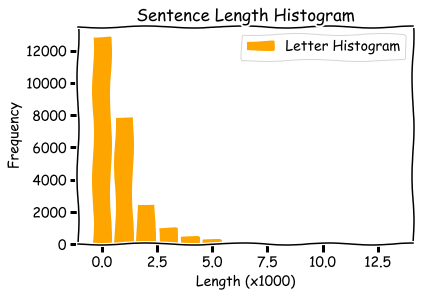

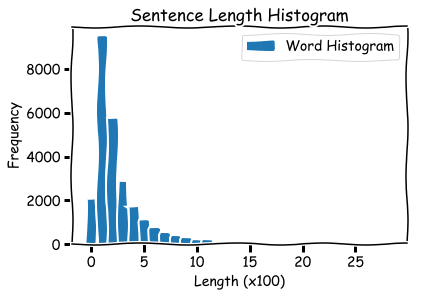

In [6]:
%matplotlib inline
from collections import defaultdict

hist = defaultdict(int)
hist_letter = defaultdict(int)

for l in lines_orginal:
    hist[int(len(l.split(' '))/100)] += 1
    hist_letter[int(len(l)/1000)] += 1
    
x = [_x for _x,_ in hist.items()]
y = [_y for _,_y in hist.items()]

x_l = [_x for _x,_ in hist_letter.items()]
y_l = [_y for _,_y in hist_letter.items()]


with plt.xkcd():
    plt.bar(x_l, y_l, color='orange',label='Letter Histogram')
    plt.title('Sentence Length Histogram')
    plt.ylabel('Frequency')
    plt.xlabel('Length (x1000)')
    plt.legend()
    plt.show()
    plt.bar(x, y, label='Word Histogram')
    plt.title('Sentence Length Histogram')
    plt.ylabel('Frequency')
    plt.xlabel('Length (x100)')
    plt.legend()
    plt.show()

If we plot the histogram for the cleaned text, we can see that most of the sentences have less than 400 words.

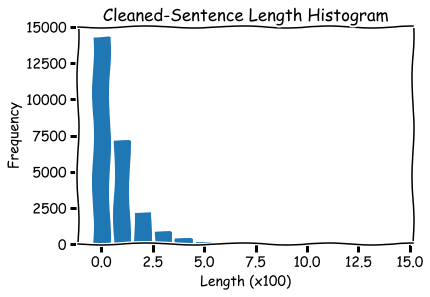

In [7]:
%matplotlib inline
from collections import defaultdict

hist = defaultdict(int)
for l in lines:
    hist[int(len(l.split(' '))/100)] += 1
    
x = [_x for _x,_ in hist.items()]
y = [_y for _,_y in hist.items()]

with plt.xkcd():
    plt.bar(x, y)
    plt.title('Cleaned-Sentence Length Histogram')
    plt.ylabel('Frequency')
    plt.xlabel('Length (x100)')
    plt.show()

## Training

The first step for training is to tokenize fix the dataset size. By tokenizing, we transform the text into integer numbers. In other words, the words are converted from string to integer in such a way that a number is assigned to each word and the sentences become numerical arrays. There is one configurable variable for this procedure, which is `top_words`. This variable indicates the maximum number of words in that language dictionary. This variable is set to 5000 for our problem which is the number of common English words. Hence, any rare word is considered `other_word` and they all get a single numerical assignment.

The next step is to fix the size of the sentences. According to the above histogram, we can see most of the sentences tends to have less than 400 words. In other words, most of the entropy of the dataset is concentrated in that area. As a result, we have chosen the maximum sentence length of our dataset to be 400 words. We clip any sentence over this number while adding space for any sentence below.

We have to mention that, before we chose to clip the dataset to 400, we have selected the maximum sentence length in the entire dataset, and add padding to every other sentence. But this turned out to not useful since it made the dataset contains mostly spaces. Which as a result, made training harder.

In [8]:
from sklearn.model_selection import train_test_split

text_data = np.array(lines)
labels = np.array(labels)
x_train, x_test, y_train, y_test = train_test_split(text_data, labels, test_size=0.2)

top_words = 5000
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test  = tokenizer.texts_to_sequences(x_test)
vocab_size = len(tokenizer.word_index) + 1

max_review_length = 400
print 'max_review_length', max_review_length

x_train = sequence.pad_sequences(x_train, padding='post', maxlen=max_review_length)
x_test  = sequence.pad_sequences(x_test,  padding='post', maxlen=max_review_length)

print 'x_train.shape =', x_train.shape
print 'y_train.shape =', y_train.shape
print 'x_test.shape =', x_test.shape
print 'y_test.shape =', y_test.shape

max_review_length 400
x_train.shape = (20000, 400)
y_train.shape = (20000,)
x_test.shape = (5000, 400)
y_test.shape = (5000,)


<hr>
As for the network, we have employed a 3-layered network followed by a single neuron output with a sigmoid activation function. The first layer is `Embedding`, which tries to convert the tokenized array with 5000-dimention to a 128-dimension space. The former structure is a one-hot-vector while the later is a normal embedding vector.

The next two layers are Bidirectional LSTM layers, with 128 and 64 neurons. Each of these layers has a 50% drop-out rate and is followed by a batch-normalization layer. We have to note that using Bidirectional-LSTM instead of normal LSTMs increased the network accuracy dramatically.

Finally, the network is trained using Adam Optimizer over binary-cross-entropy loss function.

In [9]:
model = Sequential()
model.add(Embedding(top_words, 128, input_length=max_review_length))

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(64)))#, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 128)          640000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 400, 256)          263168    
_________________________________________________________________
batch_normalization_1 (Batch (None, 400, 256)          1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 400, 256)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               164352    
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

Finally, we train the network for 10 epochs with a batch-size of 128. The network tends to converge after 10 epochs, thus we train for no further.

In [10]:
tensorboard_callback = TensorBoard(log_dir='./logs/', histogram_freq=1)
history = model.fit(
    x_train, 
    y_train, 
    validation_data=(x_test, y_test), 
    epochs=10,
    batch_size=128,
    verbose=1,
    callbacks=[tensorboard_callback]
)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 513s 26ms/step - loss: 0.6045 - acc: 0.7148 - val_loss: 2.0538 - val_acc: 0.5040
Epoch 2/10
20000/20000 [==============================] - 518s 26ms/step - loss: 0.3348 - acc: 0.8624 - val_loss: 0.5058 - val_acc: 0.7962
Epoch 3/10
20000/20000 [==============================] - 553s 28ms/step - loss: 0.2998 - acc: 0.8753 - val_loss: 1.6462 - val_acc: 0.6478
Epoch 4/10
20000/20000 [==============================] - 2684s 134ms/step - loss: 0.2731 - acc: 0.8891 - val_loss: 0.3830 - val_acc: 0.8542
Epoch 5/10
20000/20000 [==============================] - 601s 30ms/step - loss: 0.2446 - acc: 0.9043 - val_loss: 0.3849 - val_acc: 0.8460
Epoch 6/10
20000/20000 [==============================] - 574s 29ms/step - loss: 0.2175 - acc: 0.9159 - val_loss: 0.4611 - val_acc: 0.7960
Epoch 7/10
20000/20000 [==============================] - 572s 29ms/step - loss: 0.1829 - acc: 0.9322 - val_loss: 0

<hr>
In conclusion, here are the learning curves for this model. As can be inferred from the diagrams, the model is trained after a few epochs and no further training is needed.

This model can solve the test dataset with 84% accuracy while having around 98% accuracy on train data.

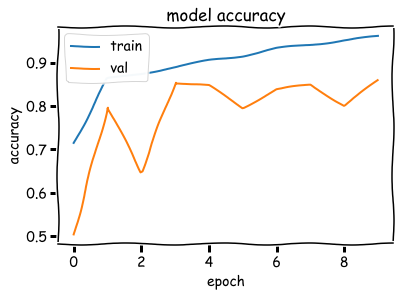

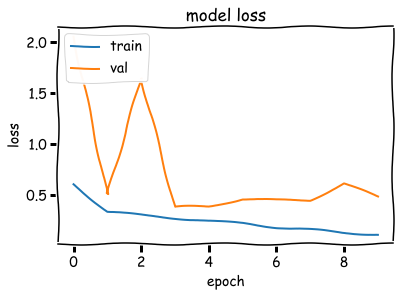

In [11]:
with plt.xkcd():
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()